In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [15]:
df = pd.read_csv('C:/Users/CSD/Desktop/data_1.csv', parse_dates = ['Date'], index_col = 'Date')
print(df.shape)
df.tail()

(563, 4)


,Mobility,New infection,New dead,Stringency index
Date,,,,
2021-08-28,-0.714,1617,3,50.93
2021-08-29,-0.857,1483,5,50.93
2021-08-30,0.857,1370,1,50.93
2021-08-31,1.143,2024,7,50.93
2021-09-01,1.286,1956,11,50.93


In [3]:
df["diff_mobility"] = df.Mobility.diff().fillna(0)
df["diff_newinfection"] = df["New infection"].diff().fillna(0)
df["diff_newdead"] = df["New dead"].diff().fillna(0)
df["diff_stringency"] = df["Stringency index"].diff().fillna(0)
df.head()

,Mobility,New infection,New dead,Stringency index,diff_mobility,diff_newinfection,diff_newdead,diff_stringency
Date,,,,,,,,
2020-02-17,-7.333,1,0,31.48,0.000,0.0,0.0,0.00
2020-02-18,-5.750,1,0,31.48,1.583,0.0,0.0,0.00
2020-02-19,-5.600,0,0,31.48,0.150,-1.0,0.0,0.00
2020-02-20,-5.833,73,1,31.48,-0.233,73.0,1.0,0.00
2020-02-21,-7.143,100,1,45.37,-1.310,27.0,0.0,13.89


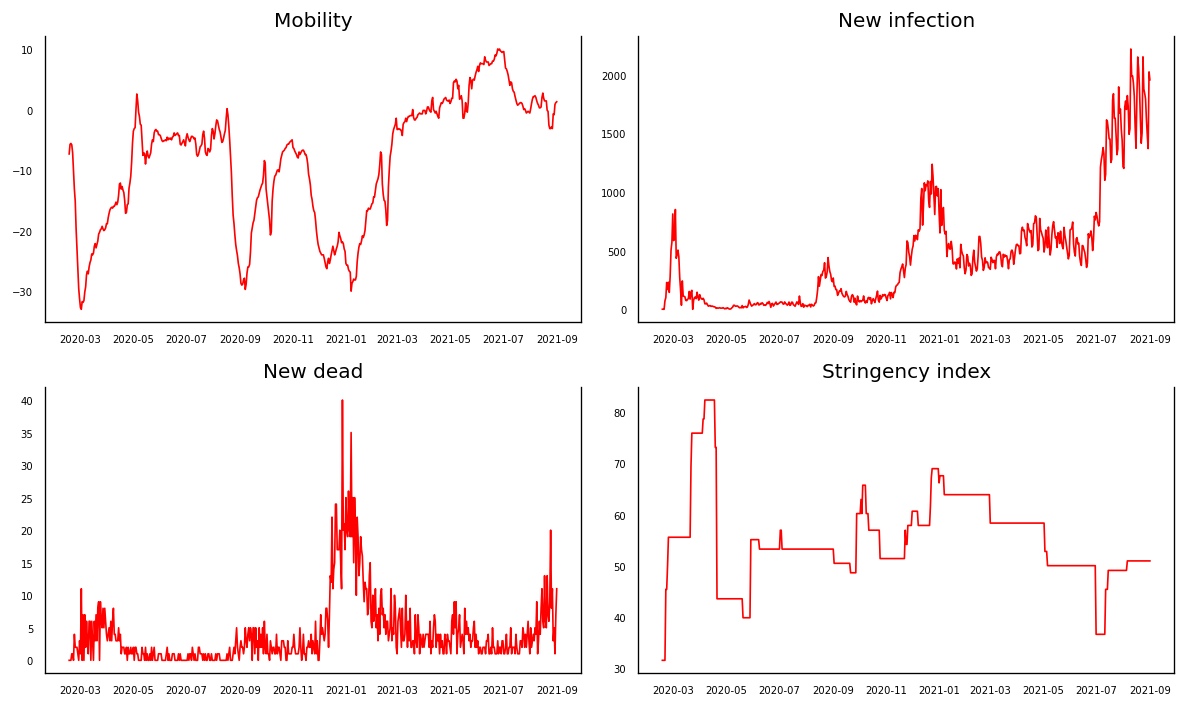

In [16]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, dpi = 120, figsize = (10, 6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color = 'red', linewidth = 1)
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)
plt.tight_layout()

In [17]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag = 12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test = 'ssr_chi2test', verbose = False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns = variables, index = variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag = maxlag, verbose = False)
            p_values = [round(test_result[i + 1][0][test][1], 4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)

,Mobility_x,New infection_x,New dead_x,Stringency index_x
Mobility_y,1.0000,0.0900,0.0086,0.0256
New infection_y,0.0000,1.0000,0.0000,0.0155
New dead_y,0.0001,0.0000,1.0000,0.0003
Stringency index_y,0.0096,0.9098,0.0206,1.0000


In [18]:
df_revised = df.drop(['Stringency index'], axis = 1)
df_revised.tail()
grangers_causation_matrix(df_revised, variables = df_revised.columns)

,Mobility_x,New infection_x,New dead_x
Mobility_y,1.0000,0.09,0.0086
New infection_y,0.0000,1.00,0.0000
New dead_y,0.0001,0.00,1.0000


In [19]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha = 0.05):
    out = coint_johansen(df, -1, 5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1 #Trace statistic
    cvts = out.cvt[:, d[str(1 - alpha)]] #Critical values (90%, 95%, 99%) for trace statistic.
    def adjust(val, length = 6): return str(val).ljust(length)
    
    print('Name   ::  Test Stat > C(95%)  =>   Signif \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace, 2), 9), ">", adjust(cvt, 8), ' =>  ', trace > cvt)
        
cointegration_test(df) # Null hypothesis can be rejected at a 95% confidence level, as the magnitude of the trace statistic is greater than the critical value
# there is at least one cointegration relationship.

Name   ::  Test Stat > C(95%)  =>   Signif 
 ----------------------------------------
Mobility ::  58.34     > 40.1749   =>   True
New infection ::  25.15     > 24.2761   =>   True
New dead ::  1.94      > 12.3212   =>   False
Stringency index ::  0.29      > 4.1296    =>   False


In [45]:
nobs =30
df_train, df_test = df_revised[0:-nobs], df_revised[-nobs:]
print(df_train.shape)
print(df_test.shape)

(533, 3)
(30, 3)


In [21]:
def adfuller_test(series, signif = 0.05, name = '', verbose = False):
    r = adfuller(series, autolag = 'AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length = 6): return str(val).ljust(length)
    
    print(f'   Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level  = {signif}')
    print(f' Test Statistic  = {output["test_statistic"]}')
    print(f' No. Lags Chosen  = {output["n_lags"]}')
    
    for key, val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')
    
    if p_value <= signif:
        print(f" => P-value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is stationary.")
    else:
        print(f" => P-value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is non-stationary.")

In [22]:
for name, column in df_train.iteritems():
    adfuller_test(column, name = column.name)
    print('\n')

   Augmented Dickey-Fuller Test on "Mobility" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level  = 0.05
 Test Statistic  = -2.283
 No. Lags Chosen  = 15
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-value = 0.1775. Weak evidence to reject the Null Hypothesis.
 => Series is non-stationary.


   Augmented Dickey-Fuller Test on "New infection" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level  = 0.05
 Test Statistic  = -0.1768
 No. Lags Chosen  = 14
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-value = 0.9412. Weak evidence to reject the Null Hypothesis.
 => Series is non-stationary.


   Augmented Dickey-Fuller Test on "New dead" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stati

In [23]:
df_differenced = df_train.diff().dropna()

In [24]:
for name, column in df_differenced.iteritems():
    adfuller_test(column, name = column.name)
    print('\n')

   Augmented Dickey-Fuller Test on "Mobility" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level  = 0.05
 Test Statistic  = -6.4626
 No. Lags Chosen  = 14
 Critical value 1%     = -3.442
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-value = 0.0. Rejecting Null Hypothesis.
 => Series is stationary.


   Augmented Dickey-Fuller Test on "New infection" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level  = 0.05
 Test Statistic  = -5.5923
 No. Lags Chosen  = 19
 Critical value 1%     = -3.443
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-value = 0.0. Rejecting Null Hypothesis.
 => Series is stationary.


   Augmented Dickey-Fuller Test on "New dead" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level  = 0.05
 Test Statisti

In [25]:
model = VAR(df_differenced)
for i in [1, 2, 3, 4, 5, 6, 7, 8, 9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC: ', result.aic)
    print('BIC: ', result.bic)
    print('FPE: ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC:  11.441422621123364
BIC:  11.534547904568836
FPE:  93099.43195995962
HQIC:  11.477794255659822 

Lag Order = 2
AIC:  11.268304005539015
BIC:  11.43149849147294
FPE:  78300.40051376748
HQIC:  11.332047372778732 

Lag Order = 3
AIC:  11.17666051847344
BIC:  11.410118254351625
FPE:  71444.21538902057
HQIC:  11.267855753250398 

Lag Order = 4
AIC:  11.086380543724683
BIC:  11.390296469326026
FPE:  65277.74167118325
HQIC:  11.205108156711256 

Lag Order = 5
AIC:  10.97172639601248
BIC:  11.346296349128343
FPE:  58207.81258227881
HQIC:  11.1180672761322 

Lag Order = 6
AIC:  10.901895419423386
BIC:  11.347316141593303
FPE:  54283.57840832687
HQIC:  11.075930836283348 

Lag Order = 7
AIC:  10.620662582988828
BIC:  11.137131725283005
FPE:  40977.97512385548
HQIC:  10.822474189331938 

Lag Order = 8
AIC:  10.483934390740568
BIC:  11.071650519589639
FPE:  35743.4549353767
HQIC:  10.713604224917813 

Lag Order = 9
AIC:  10.486871385309179
BIC:  11.146033988381674
FPE:  35851.37

C:\Users\CSD\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [26]:
x = model.select_order(maxlags = 19)
x.summary()

,AIC,BIC,FPE,HQIC
0,11.90,11.93,1.476e+05,11.91
1,11.37,11.47,8.690e+04,11.41
2,11.18,11.34,7.142e+04,11.24
3,11.09,11.32,6.520e+04,11.18
4,11.00,11.31,5.980e+04,11.12
5,10.87,11.26,5.274e+04,11.02
6,10.81,11.26,4.940e+04,10.99
7,10.52,11.04,3.694e+04,10.72
8,10.38,10.98*,3.233e+04,10.62
9,10.38,11.05,3.226e+04,10.64


In [46]:
model_fitted = model.fit(9)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 13, Oct, 2021
Time:                     21:50:46
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    11.1460
Nobs:                     549.000    HQIC:                   10.7445
Log likelihood:          -5131.64    FPE:                    35851.4
AIC:                      10.4869    Det(Omega_mle):         30881.3
--------------------------------------------------------------------
Results for equation Mobility
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.044236         0.035883            1.233           0.218
L1.Mobility              0.523551         0.044083           11.876           0.000
L1.New infection        -0.000762         0.0

In [28]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

Mobility : 1.99
New infection : 2.0
New dead : 1.95


In [47]:
lag_order = model_fitted.k_ar
print(lag_order)
forecast_input = df_differenced.values[-lag_order:]
forecast_input

9


array([[ 0.000e+00, -1.710e+02, -1.000e+00],
       [-1.572e+00, -2.530e+02,  8.000e+00],
       [-1.430e-01, -2.110e+02, -6.000e+00],
       [-2.285e+00,  8.900e+01, -1.000e+00],
       [-5.720e-01,  6.470e+02,  3.000e+00],
       [ 0.000e+00, -2.740e+02,  1.100e+01],
       [ 2.860e-01, -3.700e+01, -1.200e+01],
       [-2.860e-01, -4.800e+01,  3.000e+00],
       [ 2.429e+00, -1.760e+02, -8.000e+00]])

In [48]:
fc = model_fitted.forecast(y = forecast_input, steps = nobs)
df_forecast = pd.DataFrame(fc, index = df_revised.index[-nobs:], columns = df_revised.columns + '_1d')
df_forecast

,Mobility_1d,New infection_1d,New dead_1d
Date,,,
2021-08-03,0.843739,-195.529736,5.760482
2021-08-04,1.477919,274.941285,0.677221
2021-08-05,0.448524,260.510569,-0.983080
2021-08-06,0.855015,-98.025429,2.259776
2021-08-07,0.775769,-58.397726,-1.077837
2021-08-08,0.747488,-64.527838,-2.967739
2021-08-09,-0.784639,-171.914978,2.515606
2021-08-10,0.188168,-36.996579,-0.814157
2021-08-11,-0.265838,173.208100,1.146745


In [35]:
def invert_transformation(df_train, df_forecast):
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        df_fc[str(col) + '_forecast'] = df_train[col].iloc[-1] + df_fc[str(col) + '_1d'].cumsum()
    return df_fc

In [53]:
df_results = invert_transformation(df_train, df_forecast)
df_results.loc[:, ['Mobility_forecast', 'New infection_forecast', 'New dead_forecast']]
df_results.to_csv("C:\\Users\\CSD\\Desktop\\forecast.csv")

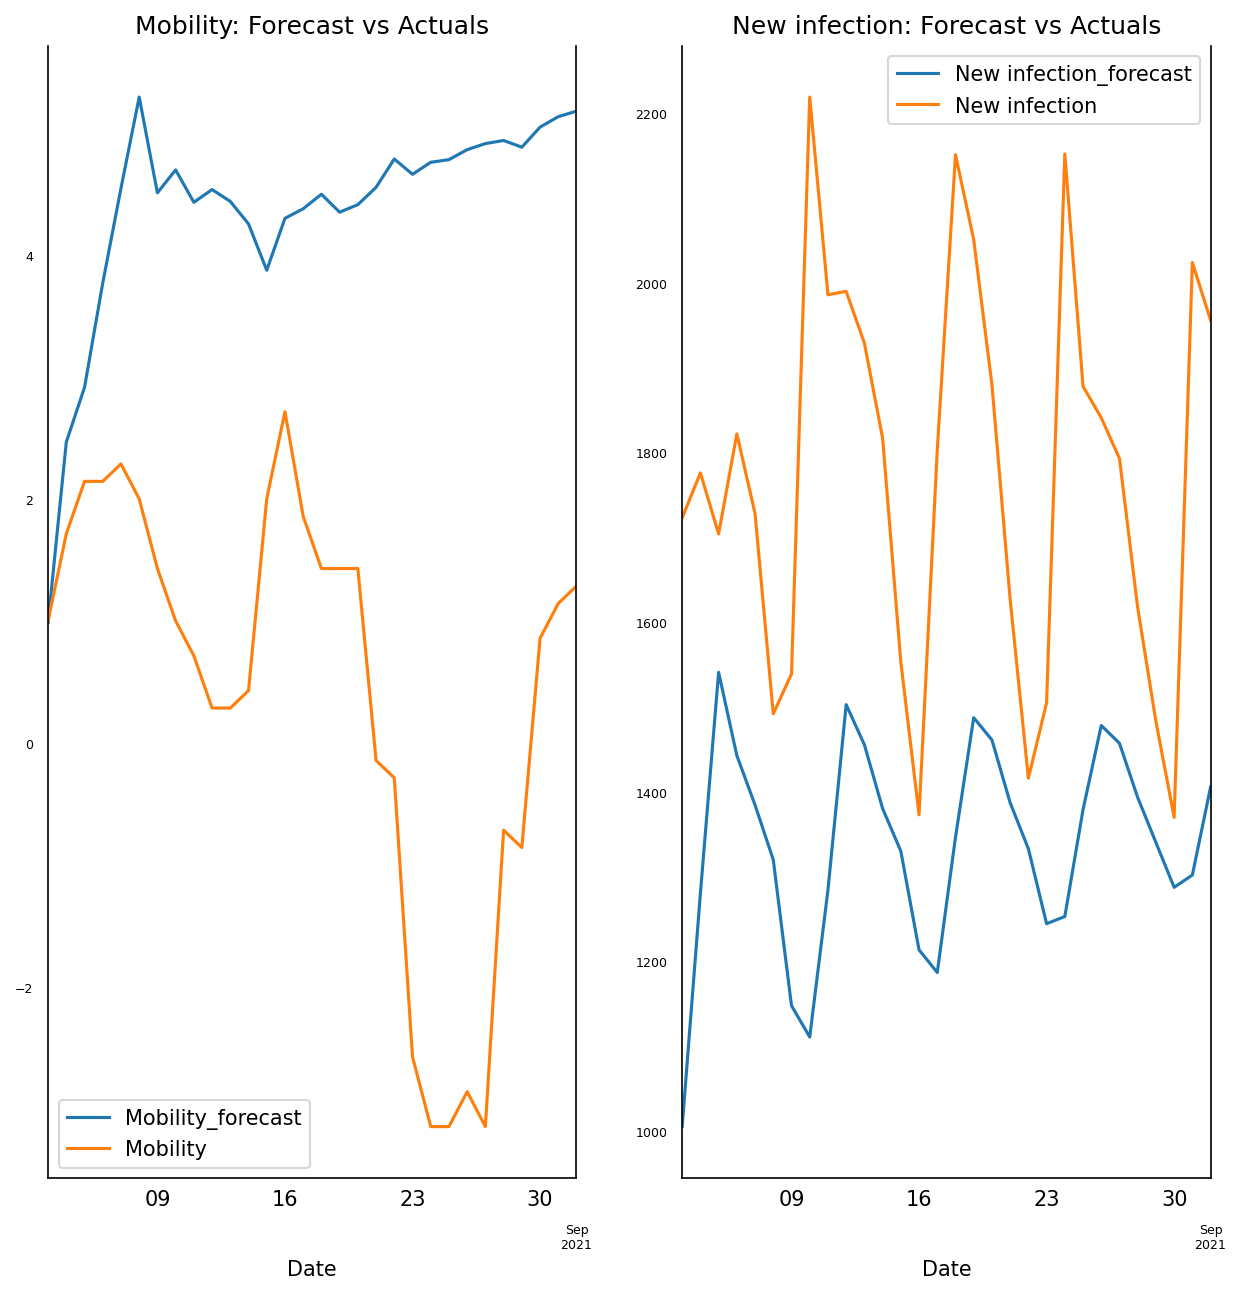

In [51]:
fig, axes = plt.subplots(nrows = int(len(df_revised.columns)/2), ncols = 2, dpi = 150, figsize = (10, 10))
for i, (col, ax) in enumerate(zip(df_revised.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend = True, ax = ax).autoscale(axis = 'x', tight = True)
    df_test[col][-nobs:].plot(legend = True, ax = ax)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.show()

In [43]:
print(df_results['Mobility_forecast'].values.shape, df_test['Mobility'].shape)

(3,) (3,)


In [54]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    me = np.mean(forecast - actual)
    mae = np.mean(np.abs(forecast - actual))
    mpe = np.mean((forecast - actual)/actual)
    rmse = np.mean((forecast - actual)**2)**.5
    corr = np.corrcoef(forecast, actual)[0, 1]
    mins = np.amin(np.hstack([forecast[:, None], actual[:, None]]), axis = 1)
    maxs = np.amax(np.hstack([forecast[:, None], actual[:, None]]), axis = 1)
    minmax = 1 - np.mean(mins/maxs)
    return({'mape': mape, 'me': me, 'mae': mae, 'mpe': mpe, 'rmse': rmse, 'corr': corr, 'minmax': minmax})

print('Forecast Accuracy of: Mobility')
accuracy_prod = forecast_accuracy(df_results['Mobility_forecast'].values, df_test['Mobility'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v, 4))
print('Forecast Accuracy of: New infection')
accuracy_prod = forecast_accuracy(df_results['New infection_forecast'].values, df_test['New infection'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v, 4))
print('Forecast Accuracy of: New dead')
accuracy_prod = forecast_accuracy(df_results['New dead_forecast'].values, df_test['New dead'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v, 4))

Forecast Accuracy of: Mobility
mape :  5.0787
me :  3.9458
mae :  3.9467
mpe :  -0.1407
rmse :  4.5046
corr :  -0.3117
minmax :  0.8513
Forecast Accuracy of: New infection
mape :  0.2334
me :  -435.125
mae :  435.125
mpe :  -0.2334
rmse :  501.0745
corr :  0.1417
minmax :  0.2334
Forecast Accuracy of: New dead
mape :  1.6666
me :  4.0491
mae :  5.0908
mpe :  1.6019
rmse :  5.8711
corr :  -0.1302
minmax :  0.4553
